# Import Libraries

In [6]:
# Core
import pandas as pd
import numpy as np

# Visualization (for feature importance, etc.)
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Modeling
from sklearn.ensemble import RandomForestClassifier
# Optional: Try others later like:
# from xgboost import XGBClassifier
# from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_fscore_support
)

# Imbalance handling (optional but important)
from imblearn.over_sampling import SMOTE  # pip install imbalanced-learn

# Explainability (optional later)
# import shap


# Basic Classification Model

In [9]:
clean_rawhistory = pd.read_csv("clean_rawhistory.csv")

In [ ]:
clean_rawhistory.head()

In [12]:
clean_rawhistory['target'] = clean_rawhistory['status'].map({'Completed': 0, 'Failed': 1})

In [13]:
model_df = clean_rawhistory[['workspacename', 'datasetname', 'Type', 'RefreshDuration_Min', 'AttemptID','target']]


In [ ]:
model_df

In [15]:
model_encoded = pd.get_dummies(
    model_df,
    columns=['workspacename', 'datasetname', 'Type'],
    drop_first=True
)

In [16]:
X = model_encoded.drop(columns='target')
y = model_encoded['target']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))


Train class distribution:
target
0    0.97549
1    0.02451
Name: proportion, dtype: float64

Test class distribution:
target
0    0.976562
1    0.023438
Name: proportion, dtype: float64


In [19]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)

In [20]:
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [21]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [22]:
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       250
           1       0.57      0.67      0.62         6

    accuracy                           0.98       256
   macro avg       0.78      0.83      0.80       256
weighted avg       0.98      0.98      0.98       256

Confusion Matrix:
 [[247   3]
 [  2   4]]
ROC AUC Score: 0.9127


In [23]:
# Predict risk scores
risk_probs = model.predict_proba(X_test)[:, 1]  # Probability of failure
X_test['risk_score'] = risk_probs

# Flag high-risk rows
X_test['risk_flag'] = X_test['risk_score'] > 0.5  # or 0.3 if you want to catch more


In [24]:
failure_rate_df = clean_rawhistory.groupby('datasetname')['status'].apply(lambda x: (x == 'Failed').mean()).reset_index(name='failure_rate')


In [ ]:
failure_rate_df

# XGBoost Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [ ]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),  # imbalance ratio
    'eta': 0.1,  # learning rate
    'max_depth': 6,
    'seed': 42,
    'use_label_encoder': False
}


In [ ]:
evals = [(dtrain, 'train'), (dtest, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    early_stopping_rounds=10,
    evals=evals,
    verbose_eval=True
)


In [ ]:
y_pred_proba = bst.predict(dtest)
y_pred = (y_pred_proba >= 0.5).astype(int)


In [ ]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")


# Hyperparameter Tuining

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


In [ ]:
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1],
    'gamma': [0, 0.1, 0.3]
}


In [ ]:
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)


In [ ]:
grid_search.fit(X_train, y_train)


In [ ]:
print("Best parameters:", grid_search.best_params_)
print(f"Best ROC AUC: {grid_search.best_score_:.4f}")


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


# SHAP

In [ ]:
import shap

# Assuming best_model is your trained XGBoost model
explainer = shap.TreeExplainer(best_model)


In [ ]:
# X_test should be your feature matrix (no target column)
shap_values = explainer.shap_values(X_test)


In [ ]:
shap.summary_plot(shap_values, X_test)


In [ ]:
shap.dependence_plot('RefreshDuration_Min', shap_values, X_test)


In [ ]:
# Choose an example row index from your test set
row_index = 0

# Force plot for that row
shap.force_plot(explainer.expected_value, shap_values[row_index], X_test.iloc[row_index], matplotlib=True)


# Raw1 Model

In [25]:
clean_raw1 = pd.read_csv("raw1.csv")

In [ ]:
clean_raw1

In [27]:
clean_raw1['target'] = clean_raw1['status'].map({'Completed': 0, 'Failed': 1})

In [28]:
model = clean_raw1[['refreshType', 'workspacename', 'datasetname', 'Type', 'RefreshDuration','target']]

In [ ]:
model

In [30]:
model_encoded = pd.get_dummies(
    model,
    columns=['refreshType','workspacename', 'datasetname', 'Type'],
    drop_first=True
)

In [31]:
X = model_encoded.drop(columns='target')
y = model_encoded['target']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [33]:
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))


Train class distribution:
target
0    0.931435
1    0.068565
Name: proportion, dtype: float64

Test class distribution:
target
0    0.932489
1    0.067511
Name: proportion, dtype: float64


In [34]:
model1 = RandomForestClassifier(class_weight='balanced', random_state=42)

In [35]:
model1.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [36]:
y_pred = model1.predict(X_test)
y_proba = model1.predict_proba(X_test)[:, 1]

In [37]:
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       221
           1       0.94      0.94      0.94        16

    accuracy                           0.99       237
   macro avg       0.97      0.97      0.97       237
weighted avg       0.99      0.99      0.99       237

Confusion Matrix:
 [[220   1]
 [  1  15]]
ROC AUC Score: 0.9997


In [45]:
importances = model1.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

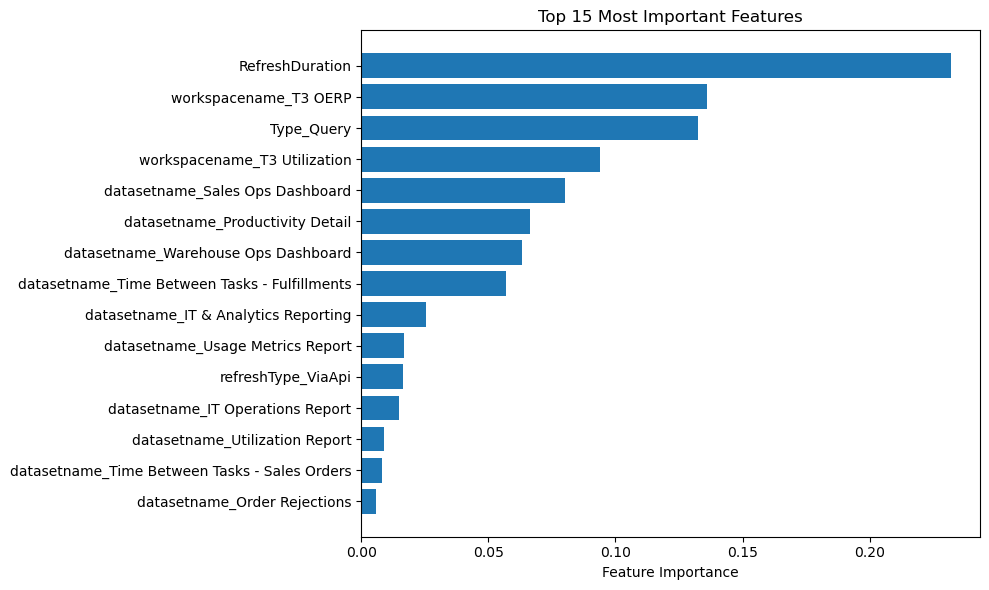

In [46]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'][:15][::-1], feature_importance_df['importance'][:15][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

In [38]:
# Predict risk scores
risk_probs = model1.predict_proba(X_test)[:, 1]  # Probability of failure
X_test['risk_score'] = risk_probs

# Flag high-risk rows
X_test['risk_flag'] = X_test['risk_score'] > 0.5  # or 0.3 if you want to catch more

In [39]:
failure_rate = clean_raw1.groupby('datasetname')['status'].apply(lambda x: (x == 'Failed').mean()).reset_index(name='failure_rate')

In [40]:
failure_rate

,datasetname,failure_rate
0,API_Demo,0.000000
1,Demo,0.000000
2,Forecast Detail,0.000000
3,HQ Operations Time Report,0.000000
4,HQ Utilization Report,0.000000
5,ISR Dashboard,0.000000
6,IT & Analytics Reporting,0.000000
7,IT Operations Report,0.000000
8,Inventory Aging Analysis,0.000000
9,Inventory Overview,0.000000


In [41]:
X_test

,RefreshDuration,refreshType_Scheduled,refreshType_ViaApi,workspacename_T3 OERP,workspacename_T3 Utilization,datasetname_Demo,datasetname_Forecast Detail,datasetname_HQ Operations Time Report,datasetname_HQ Utilization Report,datasetname_ISR Dashboard,...,datasetname_Utilization No Target,datasetname_Utilization Projection,datasetname_Utilization Reclass Report,datasetname_Utilization Report,datasetname_W2PE Utilization Report,datasetname_Warehouse Ops Dashboard,datasetname_Warehouse Productivity,Type_Query,risk_score,risk_flag
1041,0.21,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,0.0,False
1124,1.87,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,0.0,False
570,1.45,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.0,False
552,4.07,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.0,False
708,1.85,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,0.38,False,True,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,0.0,False
627,0.35,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.0,False
270,0.22,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.0,False
654,2.96,False,True,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,0.0,False


In [44]:
# Step 1: Recover datasetname from one-hot columns
datasetname_cols = [col for col in X_test.columns if col.startswith('datasetname_')]
X_test_recovered = X_test.copy()

# Extract the original datasetname from one-hot columns
X_test_recovered['datasetname'] = X_test[datasetname_cols].idxmax(axis=1).str.replace('datasetname_', '', regex=False)

# Step 2: Group by recovered datasetname and calculate failure probability
avg_failure_prob = X_test_recovered.groupby('datasetname')['risk_score'].mean().reset_index(name='failure_probability')

# Step 3: Group clean_raw1 to get actual failure rates and refresh durations
failure_rate = clean_raw1.groupby('datasetname')['status'].apply(lambda x: (x == 'Failed').mean()).reset_index(name='failure_rate')
avg_refresh_duration = clean_raw1.groupby('datasetname')['RefreshDuration'].mean().reset_index(name='refresh_duration_avg')

# Step 4: Merge all summaries
summary_df = avg_failure_prob.merge(failure_rate, on='datasetname', how='outer') \
                             .merge(avg_refresh_duration, on='datasetname', how='outer')

# Step 5: Assign risk flag
threshold = 0.5
summary_df['risk_flag'] = summary_df['failure_probability'].apply(lambda x: 'High' if x > threshold else 'Low')

# Step 6: Select top 10 high-risk datasets
top_n = 10
top_risk_datasets = summary_df.sort_values(by='failure_probability', ascending=False).head(top_n)

# Step 7: Format refresh duration nicely
top_risk_datasets['refresh_duration_avg'] = top_risk_datasets['refresh_duration_avg'].fillna(0).round(2).astype(str) + ' min'

# Final display
top_risk_datasets[['datasetname', 'failure_probability', 'failure_rate', 'refresh_duration_avg', 'risk_flag']]


,datasetname,failure_probability,failure_rate,refresh_duration_avg,risk_flag
31,Warehouse Ops Dashboard,0.988000,1.000000,0.7 min,High
22,Time Between Tasks - Fulfillments,0.984000,1.000000,0.49 min,High
20,Sales Ops Dashboard,0.940000,1.000000,0.92 min,High
15,Productivity Detail,0.862500,1.000000,1.39 min,High
29,Utilization Report,0.080000,0.025641,2.99 min,Low
12,Order Rejections,0.006667,0.000000,2.9 min,Low
23,Time Between Tasks - RMAs,0.006000,0.000000,2.55 min,Low
24,Time Between Tasks - Sales Orders,0.005000,0.000000,2.17 min,Low
32,Warehouse Productivity,0.003750,0.000000,2.67 min,Low
6,IT & Analytics Reporting,0.002500,0.000000,0.7 min,Low
